In [ ]:
!nvidia-smi

# Imports and Utility functions

## <font color='orange'>Imports</font>

In [1]:
#!pip install torchsummary torchviz

In [1]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms
from torchviz import make_dot
from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

In [2]:
np.random.seed(16)

#tf.random.set_seed(16)

## <font color='orange'>Analysing and Cleaning Data</font>

### Files

In [3]:
mrnet_path = 'D:\SiladittyaJRF\Datasets\MRNet\MRNet-v1.0'
contents = os.listdir(mrnet_path)
print(contents)
print('\nLabel Files...')
label_files = [x for x in contents if x.endswith('.csv')]
print(label_files)

['.DS_Store', 'train', 'train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']

Label Files...
['train-abnormal.csv', 'train-acl.csv', 'train-meniscus.csv', 'valid-abnormal.csv', 'valid-acl.csv', 'valid-meniscus.csv']


### Real Labels

In [4]:
#For Colab /root/MRNet/MRNet-v1.0/
trabn = pd.read_csv(mrnet_path+'\\train-abnormal.csv',header=None)
#trabn.head()
tracl = pd.read_csv(mrnet_path+'\\train-acl.csv',header=None)
#tracl.head()
trmen = pd.read_csv(mrnet_path+'\\train-meniscus.csv',header=None)
#trmen.head()

In [5]:
trabn.columns = ['patient_id','label']
tracl.columns = ['patient_id','label']
trmen.columns = ['patient_id','label']

In [6]:
tr_multilabel = trabn.merge(tracl,on='patient_id').merge(trmen,on='patient_id')
tr_multilabel.columns = ['patient_id','abn','acl','men']
tr_multilabel.head()

,patient_id,abn,acl,men
0,0,1,0,0
1,1,1,1,1
2,2,1,0,0
3,3,1,0,1
4,4,1,0,0


In [7]:
tr_multilabel.to_csv('tr_multilabl.csv',header=True)

In [8]:
#For Colab /root/MRNet/MRNet-v1.0/
valabn = pd.read_csv(mrnet_path+'\\valid-abnormal.csv',header=None)
valacl = pd.read_csv(mrnet_path+'\\valid-acl.csv',header=None)
valmen = pd.read_csv(mrnet_path+'\\valid-meniscus.csv',header=None)

In [9]:
valabn.columns = ['patient_id','label']
valacl.columns = ['patient_id','label']
valmen.columns = ['patient_id','label']

In [10]:
val_multilabel = valabn.merge(valacl,on='patient_id').merge(valmen,on='patient_id')
val_multilabel.columns = ['patient_id','abn','acl','men']
val_multilabel.head(120)

,patient_id,abn,acl,men
0,1130,0,0,0
1,1131,0,0,0
2,1132,0,0,0
3,1133,0,0,0
4,1134,0,0,0
...,...,...,...,...
115,1245,1,1,1
116,1246,1,1,1
117,1247,1,0,1
118,1248,1,1,1


### <font color='blue'>Filename DataFrame</font>

In [11]:
tr_filenames_df = pd.DataFrame(columns=['filename'])
tr_filenames_df['filename'] = os.listdir(mrnet_path+'\\train\\axial')
tr_filenames_df['patient_id'] = tr_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
tr_filenames_df = tr_filenames_df[list(('patient_id','filename'))]
tr_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

tr_filenames_df

,patient_id,filename
0,0,0000.npy
1,1,0001.npy
2,2,0002.npy
3,3,0003.npy
4,4,0004.npy
...,...,...
1125,1125,1125.npy
1126,1126,1126.npy
1127,1127,1127.npy
1128,1128,1128.npy


In [12]:
val_filenames_df = pd.DataFrame(columns=['filename'])
val_filenames_df['filename'] = os.listdir(mrnet_path+'\\valid\\axial')
val_filenames_df['patient_id'] = val_filenames_df.apply(lambda x : int(x['filename'][:-4]),axis=1)
val_filenames_df = val_filenames_df[list(('patient_id','filename'))]
val_filenames_df.sort_values(by=['patient_id'],ascending=True,inplace=True,ignore_index=True)

val_filenames_df

,patient_id,filename
0,1130,1130.npy
1,1131,1131.npy
2,1132,1132.npy
3,1133,1133.npy
4,1134,1134.npy
...,...,...
115,1245,1245.npy
116,1246,1246.npy
117,1247,1247.npy
118,1248,1248.npy


## <font color='orange'>Visualizing the Data</font>

<AxesSubplot:>

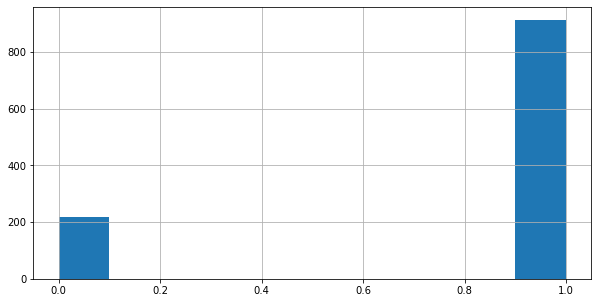

In [12]:
trabn.iloc[:,1].hist(figsize = (10, 5))

In [13]:
np.count_nonzero(trabn.iloc[:,1]==1)

913

In [ ]:
tracl.iloc[:,1].hist(figsize = (10, 5))

In [ ]:
np.count_nonzero(tracl.iloc[:,1]==1)

In [ ]:
trmen.iloc[:,1].hist(figsize = (10, 5))

In [ ]:
np.count_nonzero(trmen.iloc[:,1]==1)

In [ ]:
tr_multilabel.iloc[:,1:].hist(figsize = (10, 5))

In [ ]:
ps_labels = tr_multilabel
ps_labels.head()

In [ ]:
tr_multilabel['label'] = tr_multilabel.apply(lambda x : 4*x["abn"]+2*x["acl"]+1*x["men"],axis=1)

In [ ]:
tr_multilabel

In [ ]:
tr_multilabel.iloc[:,4].hist(figsize = (10, 5))

In [ ]:
label_map = {0:0,4:1,5:2,6:3,7:4}

In [ ]:
ps_labels['label'] = ps_labels['label'].apply(lambda x : label_map[x])

In [ ]:
ps_labels

In [ ]:
ps_labels['label'].plot.hist(bins = [-0.5,0.5,1.5,2.5,3.5,4.5],figsize = (10, 5))

In [ ]:
tr_multilabel = tr_multilabel.drop(['label'],axis=1)

### Oversampling

In [ ]:
proportions = np.array([])
for i in range(5):
    proportions = np.append(proportions,np.count_nonzero(tr_filenames_df['aclDiagnosis']==i))
        
proportions = np.min(proportions)/proportions
print(proportions)

In [ ]:
mult = proportions/min(proportions)

In [ ]:
mult

In [ ]:
for i in range(5):
    print(len(tr_multilabel))
    if mult[i]>1:
        currlabnum = np.count_nonzero(tr_multilabel['label']==i)
        finallabnum = int(np.ceil(mult[i]*currlabnum))
        print(currlabnum,finallabnum)
        gapnum = finallabnum-currlabnum
        labdf = tr_multilabel[tr_multilabel['label']==i]
        oversampled_labdf = labdf.sample(n=gapnum,replace=True)
        tr_multilabel = tr_multilabel.append(oversampled_labdf)
        print(len(tr_multilabel))
        tr_multilabel['label'].hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5])

In [ ]:
tr_multilabel = tr_multilabel.sample(frac=1,random_state=69)

In [ ]:
tr_multilabel

In [ ]:
val_multilabel.plot.hist(bins=[-0.5,0.5,1.5,2.5,3.5,4.5])

## KneeMRI DATASET

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol01.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol02.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol03.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol04.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol05.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol06.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol07.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol08.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol09.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/vol10.7z

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/metadata.csv

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/volumetric_data/example.pck

In [ ]:
!wget http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/data/example.py

## <font color='orange'>Utility Functions</font>

### <font color='blue'>Declaring the required PATH variables</font>

In [13]:
#For Colab '/root/MRNet/MRNet-v1.0/'

train_dir = mrnet_path+'\\train'
valid_dir = mrnet_path+'\\valid'
axial_mode= 'axial'
sagit_mode='sagittal'
coron_mode='coronal'
base_dir = mrnet_path

access_token = '1094213176:AAFPM2lzoWH_fvQXgDjUtluJCctamMp5Ax0'
NUM_FRAMES = 1
batch_size = 8 #32
NUM_CLASSES = 500 #3
NUM_PATCHES = 9

### <font color='blue'>Performance Metrics</font>

In [14]:
#util_wk2
def TP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def TN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def FN(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def FP(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

def get_accuracy(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return (tp+tn)/(tp+fp+tn+fn)

def get_prevalence(y):
    return np.sum(y)/y.shape[0]

def sensitivity(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fn = FN(y,pred,th)
    
    return tp/(tp+fn)

def specificity(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fp = FP(y,pred,th)
    
    return tn/(tn+fp)

def get_ppv(y, pred, th=0.5):
    tp = TP(y,pred,th)
    fp = FP(y,pred,th)
    
    return tp/(tp+fp)

def get_npv(y, pred, th=0.5):
    tn = TN(y,pred,th)
    fn = FN(y,pred,th)
    
    return tn/(tn+fn)


def get_performance_metrics(y, pred, class_labels, tp=TP,
                            tn=TN, fp=FP,
                            fn=FN,
                            acc=get_accuracy, prevalence=get_prevalence, 
                            spec=specificity,sens=sensitivity, ppv=get_ppv, 
                            npv=get_npv, auc=roc_auc_score, f1=f1_score,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    columns = ["", "TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
               "Sensitivity",
               "Specificity", "PPV", "NPV", "AUC", "F1", "Threshold"]
    df = pd.DataFrame(columns=columns)
    for i in range(len(class_labels)):
        df.loc[i] = [""] + [0] * (len(columns) - 1)
        df.loc[i][0] = class_labels[i]
        df.loc[i][1] = round(tp(y[:, i], pred[:, i]),
                             3) if tp != None else "Not Defined"
        df.loc[i][2] = round(tn(y[:, i], pred[:, i]),
                             3) if tn != None else "Not Defined"
        df.loc[i][3] = round(fp(y[:, i], pred[:, i]),
                             3) if fp != None else "Not Defined"
        df.loc[i][4] = round(fn(y[:, i], pred[:, i]),
                             3) if fn != None else "Not Defined"
        df.loc[i][5] = round(acc(y[:, i], pred[:, i], thresholds[i]),
                             3) if acc != None else "Not Defined"
        df.loc[i][6] = round(prevalence(y[:, i]),
                             3) if prevalence != None else "Not Defined"
        df.loc[i][7] = round(sens(y[:, i], pred[:, i], thresholds[i]),
                             3) if sens != None else "Not Defined"
        df.loc[i][8] = round(spec(y[:, i], pred[:, i], thresholds[i]),
                             3) if spec != None else "Not Defined"
        df.loc[i][9] = round(ppv(y[:, i], pred[:, i], thresholds[i]),
                             3) if ppv != None else "Not Defined"
        df.loc[i][10] = round(npv(y[:, i], pred[:, i], thresholds[i]),
                              3) if npv != None else "Not Defined"
        df.loc[i][11] = round(auc(y[:, i], pred[:, i]),
                              3) if auc != None else "Not Defined"
        df.loc[i][12] = round(f1(y[:, i], pred[:, i] > thresholds[i]),
                              3) if f1 != None else "Not Defined"
        df.loc[i][13] = round(thresholds[i], 3)

    df = df.set_index("")
    return df

def bootstrap_metric(y, pred, classes, metric='auc',bootstraps = 100, fold_size = 1000):
    statistics = np.zeros((len(classes), bootstraps))
    if metric=='AUC':
        metric_func = roc_auc_score
    if metric=='Sensitivity':
        metric_func = sensitivity
    if metric=='Specificity':
        metric_func = specificity
    if metric=='Accuracy':
        metric_func = get_accuracy
    for c in range(len(classes)):
        df = pd.DataFrame(columns=['y', 'pred'])
        df.loc[:, 'y'] = y[:, c]
        df.loc[:, 'pred'] = pred[:, c]
        # get positive examples for stratified sampling
        df_pos = df[df.y == 1]
        df_neg = df[df.y == 0]
        prevalence = len(df_pos) / len(df)
        for i in range(bootstraps):
            # stratified sampling of positive and negative examples
            pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
            neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

            y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
            pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
            score = metric_func(y_sample, pred_sample)
            statistics[c][i] = score
    return statistics

def get_confidence_intervals(y,pred,class_labels):
    
    metric_dfs = {}
    for metric in ['AUC','Sensitivity','Specificity','Accuracy']:
        statistics = bootstrap_metric(y,pred,class_labels,metric)
        df = pd.DataFrame(columns=["Mean "+metric+" (CI 5%-95%)"])
        for i in range(len(class_labels)):
            mean = statistics.mean(axis=1)[i]
            max_ = np.quantile(statistics, .95, axis=1)[i]
            min_ = np.quantile(statistics, .05, axis=1)[i]
            df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
        metric_dfs[metric] = df
    return metric_dfs


### <font color='blue'>Plotting Metrics</font>

#### <font color='red'>Accuracy</font>

In [15]:
def plot_accuracy(tr_acc,val_acc):
    # Plot training & validation accuracy values
    plt.plot(tr_acc)
    plt.plot(val_acc)
    plt.title('Model accuracy',fontsize=10)
    plt.ylabel('Accuracy',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('accuracy_plot.png')
    plt.show()

#### <font color='red'>Loss</font>

In [16]:
def plot_loss(tr_loss,val_loss):
    # Plot training & validation loss values
    plt.plot(tr_loss)
    plt.plot(val_loss)
    plt.title('Model loss',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.xlabel('Epoch',fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.legend(['Train', 'Validation'], loc='upper left',prop={'size': 10})
    plt.savefig('loss_plot.png')
    plt.show()

#### <font color='red'>ROC</font>

In [17]:
def get_roc_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " AUC: %.3f " % auc_roc
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('ROC_Curve.png')
        plt.show()

#### <font color='red'>Precision and Recall</font>

In [18]:
def get_PR_curve(gt, pred, target_names):
    for i in range(len(target_names)):
        precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
        average_precision = average_precision_score(gt[:, i], pred[:, i])
        label = str(target_names[i]) + " Avg.: %.3f " % average_precision
        plt.figure(1, figsize=(7, 7))
        plt.step(recall, precision, where='post', label=label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        plt.savefig('Precision_and_Recall_curve.png')
        plt.show()

#### <font color='red'>Confusion Matrix</font>  

In [19]:
def plot_confusion_matrix(y_true,y_pred,class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=(60,60))
    sns.set(font_scale=3.0) # Adjust to fit
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)
    fig.savefig('Confusion_Matrix.png')
    plt.show()

#### <font color='red'>Performance Metrics with Errorbars</font>

In [20]:
#04_03_Errorbar.ipynb
def plot_perf_metrics_errbars(y,pred,class_labels):
    metric_dfs = get_confidence_intervals(y,pred,class_labels)
    metrics = metric_dfs.keys()
    fig,axs = plt.subplots(len(metrics),1,sharey=True)
    for i in range(len(metrics)):
        ci = metric_dfs[metric][['Mean '+metrics[i]+' (CI 5%-95%)']].values
        ci_mean,ci_ints = np.array([c[0].split(' ') for c in ci]).T
        ci_mean = ci_mean.astype(float)
        ci_min,ci_max = np.array([ci_ints.strip('()').split('-')]).astype(float)
        ci_err = (ci_max-ci_min)/2
        
        axs[i].errorbar(class_labels,ci_mean,yerr=ci_err,capsize=5,fmt='dk')
        axs[i].set_ylabel(metrics[i])
    fig.savefig('Performance_Metrics_95percentCI.png')
    plt.show()

# <font color='green'>Approach 1 : Jumbled Patch Order Prediction</font>



## <font color='orange'>Preparing Pseudo Labels</font>

NEEDS TO BE RUN


In [21]:
def build_pseudo_GTP_labels():
    ROTATION = [-15,0,15]
    TRANSLATEX = [-6,0,6]
    TRANSLATEY = [-6,0,6]
    SCALING = [1,1.1]
    SHEAR = []
    classes = {}
    cind = 0
    for rot in ROTATION:
        for tranX in TRANSLATEX:
            for tranY in TRANSLATEY:
                for sc in SCALING:
                    classes[cind] = [rot,tranX,tranY,sc]
                    cind+=1
    return classes


GTP_LABELS = build_pseudo_GTP_labels()

In [23]:
#GTP_LABELS

### PPP Pseudo Labels

In [22]:
NUM_PATCHES = 9

In [23]:
def build_pseudo_ppp_labels(num_patches):
    ppp_labels_perms = list(permutations(range(0,num_patches)))
    ppp_labels_perms = [list(t) for t in ppp_labels_perms]
    #print(ppp_labels_perms)

    ppp_labels = {}
    label_num= 0
    for key in ppp_labels_perms:
        ppp_labels[str(key)] = label_num
        label_num+=1
    
    return ppp_labels

PPP_LABELS = build_pseudo_ppp_labels(NUM_PATCHES)

In [24]:
#print(PPP_LABELS)

In [25]:
keys = random.sample(list(PPP_LABELS.keys()),500)
if '[0, 1, 2, 3, 4, 5, 6, 7, 8]' not in keys:
    PPP_LABELS_DICT = {'[0, 1, 2, 3, 4, 5, 6, 7, 8]':0}
    keys = keys[:-1]
    v = 1
else:
    v = 0
for k in keys:
    PPP_LABELS_DICT[k] = v
    v+=1
#print(PPP_LABELS_DICT)

In [26]:
PPP_LABELS = PPP_LABELS_DICT

In [27]:
'[0, 1, 2, 3, 4, 5, 6, 7, 8]' in PPP_LABELS.keys()

True

In [28]:
len(PPP_LABELS)

500

## SSL PPP Data Generator

In [29]:
NUM_PATCHES = 9
NUM_CLASSES = 500

In [30]:
def ppi_irv2(x):
    x /= 127.5
    x -= 1.
    return x

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [48]:
class PPPDataGen(Dataset):
    def __init__(self,phase,mode,base_dir,filenames_df,preprocess_input=None,
                 ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,
                 batch_size=8,num_patches = NUM_PATCHES,num_frames = NUM_FRAMES,
                 num_classes=NUM_CLASSES,hor_flip = True,data_aug = True):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'\\'+phase+'\\'+mode
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.mode = mode
        self.batch_size = batch_size
        self.num_patches = num_patches
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
        self.ppp_labels_dict = ppp_labels_dict
        self.gtp_labels_dict = gtp_labels_dict 
        self.hor_flip = hor_flip
        self.data_aug = data_aug
        
        self.invGamma100 = 1.0 
        self.invGamma115 = 1.0/1.15
        self.invGamma085 = 1.0/0.85
        self.table100 = np.array([((k / 255.0) ** self.invGamma100) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table115 = np.array([((k / 255.0) ** self.invGamma115) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.table085 = np.array([((k / 255.0) ** self.invGamma085) * 255 for k in np.arange(0, 256)]).astype("uint8")
        self.gamma_dict100 = dict(zip(range(256),self.table100))
        self.gamma_dict115 = dict(zip(range(256),self.table115))
        self.gamma_dict085 = dict(zip(range(256),self.table085))


    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        file_idx = file_idx%filePoolLen #//(16//self.batch_size)# #np.random.randint(0,filePoolLen)
        npy_file = np.load(self.ph_mode_dir+'\\'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,idx)
        tot_frames = image_volume.shape[0]
        frame_idxs = np.random.randint(0,tot_frames,size=self.num_frames)
        frames = np.array(image_volume[frame_idxs,:,:])
        #print(frames.shape)
        return frames
    
    def __len__(self):
        #return int(np.floor((len(self.filenames_df)/self.batch_size)))
        return len(self.filenames_df) #*16
    
    def __getitem__(self,idx):

        #DECLARE VARIABLES
        batch_imgs = np.array([]).reshape((0,256,256,3))

        model1_inp = np.array([]).reshape((0,64,64,3))
        model2_inp = np.array([]).reshape((0,64,64,3))
        model3_inp = np.array([]).reshape((0,64,64,3))
        model4_inp = np.array([]).reshape((0,64,64,3))
        model5_inp = np.array([]).reshape((0,64,64,3))
        model6_inp = np.array([]).reshape((0,64,64,3))
        model7_inp = np.array([]).reshape((0,64,64,3))
        model8_inp = np.array([]).reshape((0,64,64,3))
        model9_inp = np.array([]).reshape((0,64,64,3))

        batch_labs = np.array([],dtype=np.int32)
        
        #CREATE BATCH
        '''for bs in range(self.batch_size):
            #print(bs)
            #GET CLIP FRAMES'''
        file_idx = idx #self.start_idx + bs
        imgs = np.array([]).reshape((256,256,0))
        img = self.get_frames(self.mode,idx)
        for i in range(3):
            imgs = np.append(imgs,img.reshape((256,256,1)),axis=2)

        batch_imgs = np.append(batch_imgs,np.expand_dims(imgs,axis=0),axis=0)

        ppp_labels = list(self.ppp_labels_dict.keys())
        #print(len(ppp_labels))
        crop_window = int(256/int(np.sqrt(self.num_patches)))
        crop_window_rlx = 64 #################################int(crop_window - np.ceil(0.2*float(crop_window)))
        eachgap = int((crop_window-crop_window_rlx)/2.)

        for i in range(batch_imgs.shape[0]):
            '''if self.phase=='train':
                batch_imgs[i] = self.gamma_correction(batch_imgs[i])'''
                #batch_imgs[i] = np.clip(batch_imgs[i] + np.random.normal(0,0.1,(256,256,3)),0,255)
            
            label_idx = np.random.choice(list(range(self.num_classes)))
            #print(ppp_labels[label_idx])
            jumbling_order = list(map(int,ppp_labels[label_idx].strip('[]').split(',')))
            temp_batch_img = np.zeros((64,64,3))
            for jo in range(len(jumbling_order)):
                temp_patch1 = np.zeros((crop_window_rlx,crop_window_rlx,3))
                spatch_num = jumbling_order[jo]
                scol_num = spatch_num%int(np.sqrt(self.num_patches))
                srow_num = int(np.floor(spatch_num/int(np.sqrt(self.num_patches))))
                gapx = np.random.randint(0,eachgap)
                gapy = np.random.randint(0,eachgap)
                sourcesx = crop_window*scol_num + gapx
                sourceex = sourcesx + crop_window_rlx
                sourcesy = crop_window*srow_num + gapy
                sourceey = sourcesy + crop_window_rlx
                #sx = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
                #sy = np.random.choice(range(int(eachgap/4.),int(eachgap/4.)+int(eachgap/2.)))
                #temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

                #AUGMENT FRAMES
                if self.phase=='train':
                    temp_patch1 = self.__augment(batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:])
                else:
                    temp_patch1 = batch_imgs[i,sourcesx:sourceex,sourcesy:sourceey,:]

                if jo == 0:
                    model1_inp = np.append(model1_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 1:
                    model2_inp = np.append(model2_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 2:
                    model3_inp = np.append(model3_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 3:
                    model4_inp = np.append(model4_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 4:
                    model5_inp = np.append(model5_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 5:
                    model6_inp = np.append(model6_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 6:
                    model7_inp = np.append(model7_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 7:
                    model8_inp = np.append(model8_inp,np.expand_dims(temp_patch1,axis=0),axis=0)
                if jo == 8:
                    model9_inp = np.append(model9_inp,np.expand_dims(temp_patch1,axis=0),axis=0)

            batch_labs = np.append(batch_labs,int(self.ppp_labels_dict[ppp_labels[label_idx]]))

        #PREPROCESS FRAMES
        model1_inp = self.preprocess_input(model1_inp)
        model2_inp = self.preprocess_input(model2_inp)
        model3_inp = self.preprocess_input(model3_inp)
        model4_inp = self.preprocess_input(model4_inp)
        model5_inp = self.preprocess_input(model5_inp)
        model6_inp = self.preprocess_input(model6_inp)
        model7_inp = self.preprocess_input(model7_inp)
        model8_inp = self.preprocess_input(model8_inp)
        model9_inp = self.preprocess_input(model9_inp)
        
        #return inputs, batch_labs
        return np.array([model1_inp,model2_inp,model3_inp,model4_inp,model5_inp,model6_inp,model7_inp,model8_inp,model9_inp]),batch_labs
        
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
    
    def on_epoch_end(self):
        self.filenames_df = self.filenames_df.sample(frac=1).reset_index(drop=True)

    def gamma_correction(self,temp_patch):
        
        gamma_val = np.random.choice([0,1,2])
        if gamma_val == 0:
            temp_patch = np.vectorize(self.gamma_dict100.get)(temp_patch.astype('int'))
        if gamma_val == 1:
            temp_patch = np.vectorize(self.gamma_dict115.get)(temp_patch.astype('int'))
        if gamma_val == 2:
            temp_patch = np.vectorize(self.gamma_dict085.get)(temp_patch.astype('int'))

        return temp_patch
    
    def __augment(self,temp_patch):

        transforms = np.random.choice(list(self.gtp_labels_dict.keys()))
        transformations = self.gtp_labels_dict[transforms]
        temp_patch = rotate(temp_patch,transformations[0],preserve_range=True)
        temp_patch = warp(temp_patch,
                          AffineTransform(matrix=np.array([[transformations[3], 0, transformations[1]],
                                                           [0,transformations[3],  transformations[2]],
                                                           [0,         0,                   1]])).inverse,
                          preserve_range=True)
            
        if self.hor_flip:
            if np.random.choice([True,False]):
                temp_patch = np.flip(temp_patch,axis=2)

        if np.random.choice([True,False]):
            temp_patch = np.clip(temp_patch*np.random.choice([0.85,0.9,1.0,1.1,1.15]),0,255)
        

        return temp_patch

### Datagen Testing

In [34]:
dg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)

In [35]:
dl = DataLoader(dg,batch_size=16)

In [42]:
for x,y in dl:
    print(type(x[0]),type(y))

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


In [46]:
print(x[0][0].shape)

torch.Size([1, 64, 64, 3])


In [ ]:
samples = {}
for i in range(1000):
    _,gtp_labs = dg.__getitem__(i)
    for t in gtp_labs:
        if t not in list(samples.keys()):
            samples[int(t)]=0
        samples[int(t)]+=1
plt.bar(list(samples.keys()),list(samples.values()))
plt.show()


In [ ]:
np.max(ppp_imgs[4][5])

In [ ]:
np.max(np.random.normal(0,0.1,(64,64,3)))

In [ ]:
plt.imshow((ppp_imgs[4][5]+1)/2.0,cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

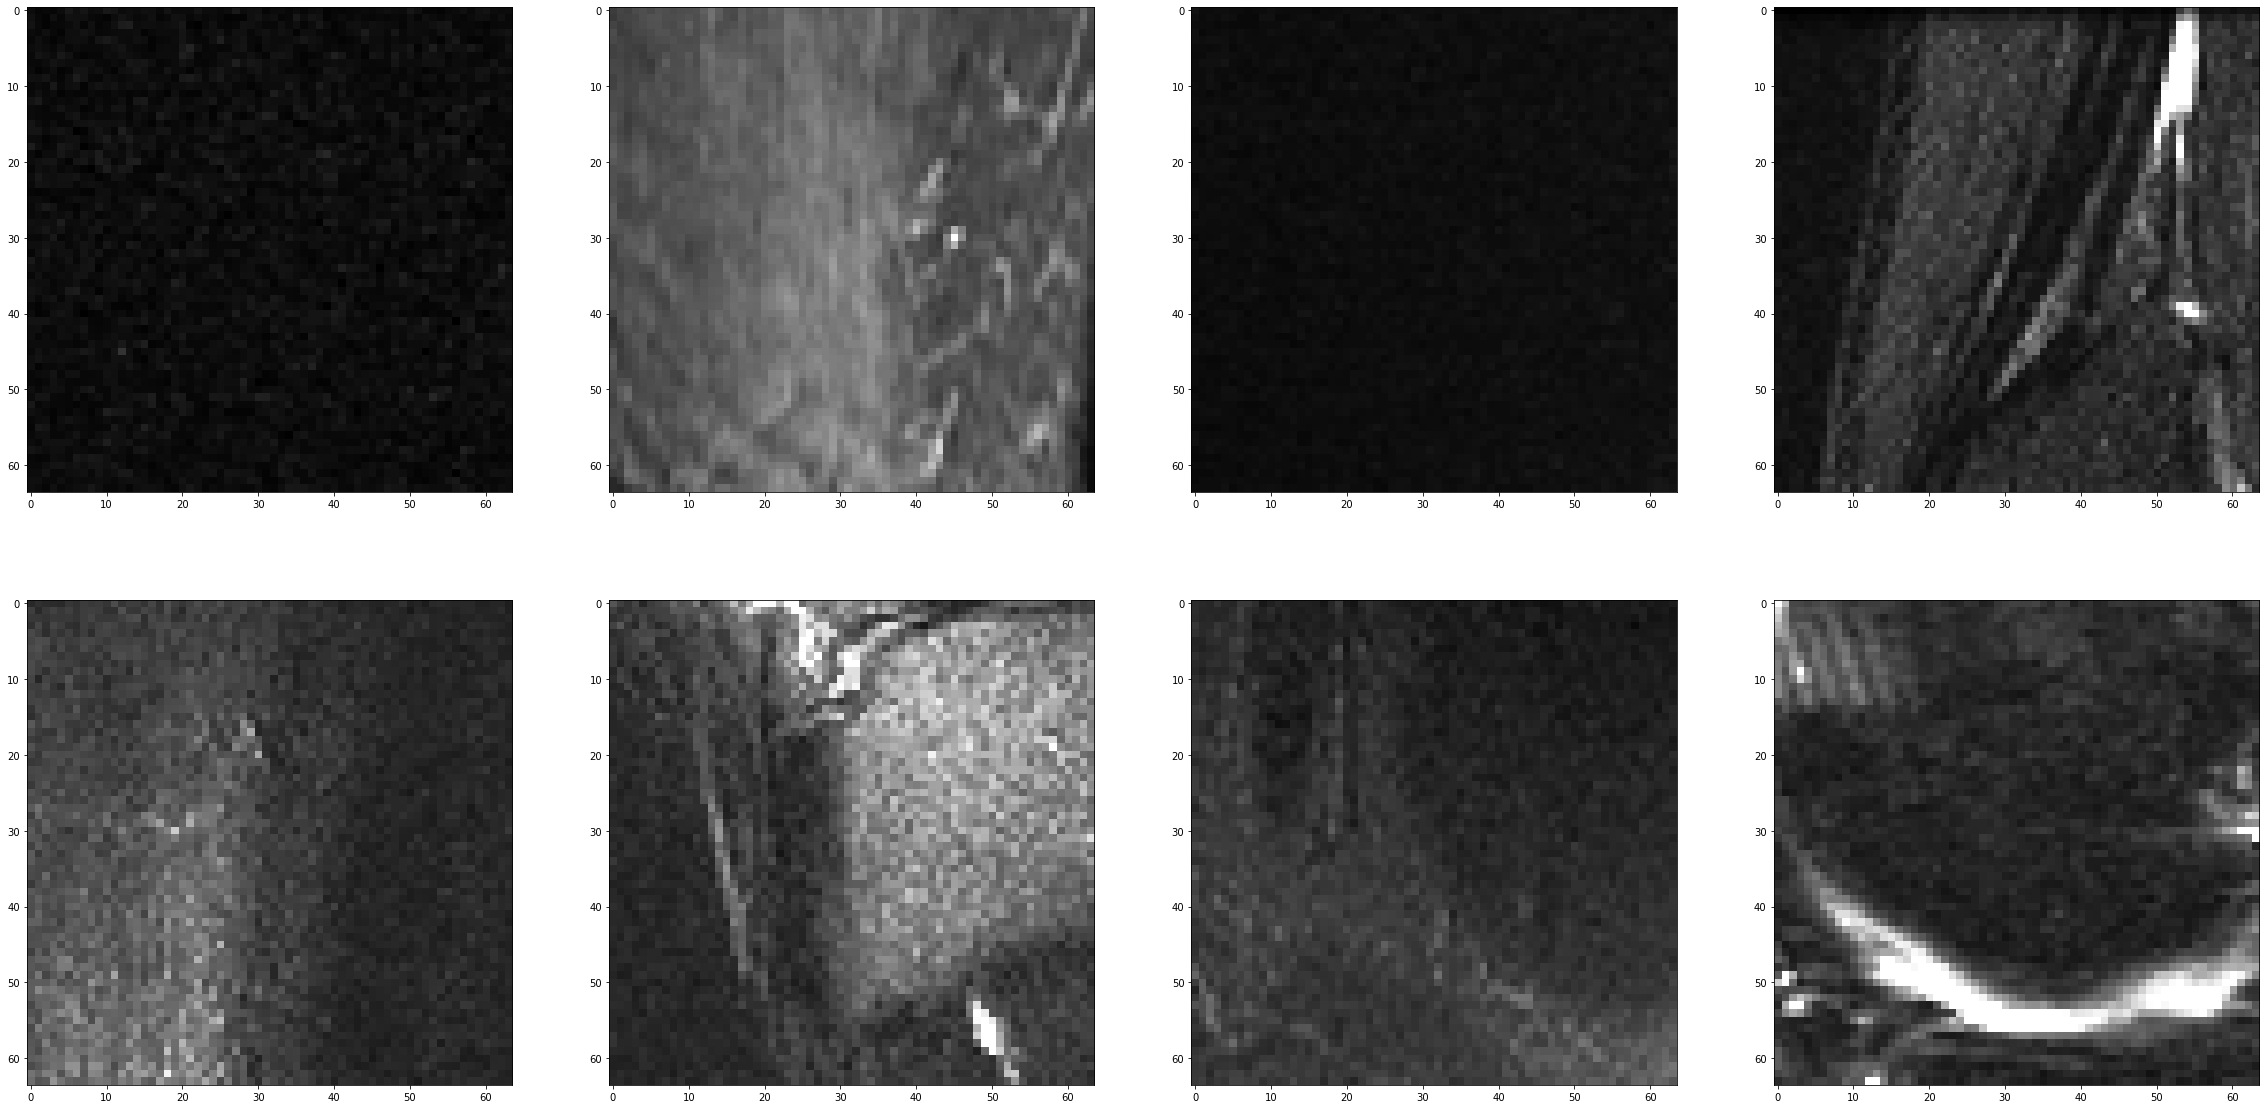

In [50]:
fig,axs=plt.subplots(2,4,figsize=(40,20))
for i in range(8):
    axs[int(i/4),i%4].imshow((x[0][i][0]+1)/2.0,cmap='gray')
    #axs[int(i/4),i%4].set_title(str(list(PPP_LABELS.keys())[ppp_labs[i]]))
plt.show()

## Manual Model

In [32]:
SEED = 16

In [39]:
def conv3x3(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=3,stride = stride, padding = padding)

def conv1x1(inC,outC,stride=1,padding=1):
    return nn.Conv2d(inC,outC,kernel_size=1,stride = stride, padding = padding)

def norm_layer(inC):
    return nn.BatchNorm2d(inC)

def maxpool(kernel_size = 2, stride = 2):
    return nn.MaxPool2d(kernel_size = kernel_size, stride = stride)

def avgpool(kernel_size = 2, stride = 2):
    return nn.AvgPool2d(kernel_size = kernel_size, stride = stride)

class Conv_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Conv_block,self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        self.outC1 = self.outC // upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1,self.outC1)
        self.bn2 = norm_layer(self.outC1)
        self.conv3 = conv3x3(self.outC1,self.outC2)
        self.bn3 = norm_layer(self.outC2)
        self.conv4 = conv3x3(self.outC2,self.outC2)
        self.bn4 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        self.downsample = maxpool()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu(out)
        
        out = self.downsample(out)
        #print(out.shape)
        
        return out
    
class Skip_block(nn.Module):
    def __init__(self,inC,outC,upsample = 2,**kwargs):
        super(Skip_block, self).__init__()
        self.inC = inC
        self.outC = outC
        self.upsample = upsample
        try:
            self.scale  = kwargs['scale']
        except:
            self.scale = 1.0
        
        self.outC1 = self.outC//self.upsample
        self.outC2 = self.outC
        
        self.conv1 = conv3x3(self.inC,self.outC1)
        self.bn1 = norm_layer(self.outC1)
        self.conv2 = conv3x3(self.outC1, self.outC2)
        self.bn2 = norm_layer(self.outC2)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        #print("SKIP::",out.shape)
        out = self.scale*out + identity
        #print(out.shape)
        
        return out

class Dim_Red_block(nn.Module):
    def __init__(self,inC,outC,upsample = 1,**kwargs):
        super(Dim_Red_block,self).__init__()
        self.inC= inC
        self.upsample = upsample
        self.outC = outC
        
        self.outC1 = (self.outC//2)//self.upsample
        self.outC2 = self.outC//2
        
        try:
            self.downfactor = kwargs['downfactor']
        except:
            self.downfactor = 2
            
        if self.downfactor == 2:
            self.stride1 = 1
        elif self.downfactor == 4:
            self.stride1 = 2
        self.stride2 = 2
        
        self.conv11 = conv3x3(self.inC, self.outC1, stride = self.stride1)
        self.bn11 = norm_layer(self.outC1)
        self.conv12 = conv3x3(self.outC1, self.outC2, stride = self.stride2)
        self.bn12 = norm_layer(self.outC2)
        
        self.downsample21 = avgpool()
        self.conv22 = conv1x1(self.inC,self.outC2,padding = 0)
        self.bn22 = norm_layer(self.outC2)
        
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self,x):
        out1 = self.conv11(x)
        out1 = self.bn11(out1)
        out1 = self.relu(out1)
        #print("DIMRED:",out1.shape)
        out1 = self.conv12(out1)
        out1 = self.bn12(out1)
        out1 = self.relu(out1)
        #print(out1.shape)
        
        out2 = self.downsample21(x)
        out2 = self.conv22(out2)
        out2 = self.bn22(out2)
        out2 = self.relu(out2)
        #print(out2.shape)
        
        out = torch.cat((out1,out2),dim=1)
        
        return out
    
class JPOP_net(nn.Module): 
    def __init__(self,conv_block,skip_block,dim_red_block, layer_outs, input_shape = (3,64,64), num_classes = 500):
        super(JPOP_net,self).__init__()
        self.conv_block = conv_block
        self.skip_block = skip_block
        self.dim_red_block = dim_red_block
        self.input_shape = input_shape
        self.inC = self.input_shape[0]
        self.num_classes = num_classes
        
        self.conv_channel1 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel2 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel3 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel4 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel5 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel6 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel7 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel8 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        self.conv_channel9 = self._make_layer(self.conv_block,self.inC,layer_outs[0],2)
        
        self.conv1x1layer = conv1x1(9*layer_outs[0],layer_outs[1],padding=0)
        
        self.skip_block1 = self._make_layer(self.skip_block,layer_outs[1],layer_outs[2],upsample = 2, scale = 1.0)
        
        self.dim_red_block1 = self._make_layer(self.dim_red_block,layer_outs[2],layer_outs[3],upsample = 1, downfactor = 2)
        
        self.skip_block2 = self._make_layer(self.skip_block,layer_outs[3],layer_outs[4],upsample = 2, scale = 1.0)
        
        self.dim_red_block2 = self._make_layer(self.dim_red_block,layer_outs[4],layer_outs[5],upsample = 1, downfactor = 2)
        
        self.globalavgpool = avgpool(kernel_size = 4, stride = 4)
        
        self.fc1 = nn.Linear(layer_outs[5],1024)
        self.fc2 = nn.Linear(1024,1024)
        
        self.output = nn.Linear(1024,self.num_classes)
    
    def _make_layer(self,block,inC,outC,upsample,**kwargs):
        layers = [block(inC,outC,upsample,**kwargs)]
        return nn.Sequential(*layers)
    
    def _forward_impl(self,x):
        #print(x.shape,x.select(1,0).shape)
        out1 = self.conv_channel1(x.select(1,0).to(memory_format=torch.channels_last))
        out2 = self.conv_channel2(x.select(1,1).to(memory_format=torch.channels_last))
        out3 = self.conv_channel3(x.select(1,2).to(memory_format=torch.channels_last))
        out4 = self.conv_channel4(x.select(1,3).to(memory_format=torch.channels_last))
        out5 = self.conv_channel5(x.select(1,4).to(memory_format=torch.channels_last))
        out6 = self.conv_channel6(x.select(1,5).to(memory_format=torch.channels_last))
        out7 = self.conv_channel7(x.select(1,6).to(memory_format=torch.channels_last))
        out8 = self.conv_channel8(x.select(1,7).to(memory_format=torch.channels_last))
        out9 = self.conv_channel9(x.select(1,8).to(memory_format=torch.channels_last))
        
        out = torch.cat((out1,out2,out3,out4,out5,out6,out7,out8,out9),dim = 1)
        #print(out.shape)
        out = self.conv1x1layer(out)
        #print(out.shape)
        out = self.skip_block1(out)
        #print(out.shape)
        out = self.dim_red_block1(out)
        out = self.skip_block2(out)
        out = self.dim_red_block2(out)
        
        out = self.globalavgpool(out)
        #print(out.shape)
        out = torch.flatten(out,1)
        #print(out.shape)
        out = self.fc1(out)
        #print(out.shape)
        out = self.fc2(out)
        #print(out.shape)
        out = self.output(out)
        
        return out
    
    def forward(self,x):
        return self._forward_impl(x)
    
def model(conv_block,skip_block,dim_red_block,layer_outs,input_shape = (3,64,64),num_classes = 500):
    return JPOP_net(conv_block,skip_block,dim_red_block,layer_outs,input_shape,num_classes)

### OPTIMIZER AND DATA GEN

In [ ]:
#optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 1000,decay_rate=0.97,staircase=True), momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.Adam(lr= 0.0003) #lr = 1e-5 for finetuning whole 1e-4 for only FC
#optimizer = tf.keras.optimizers.RMSprop(learning_rate =tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 2260,decay_rate=0.95,staircase=True),rho=0.9)

In [56]:
class AccumOptimizer(Optimizer):
    
    def __init__(self, optimizer, steps_per_update=1, **kwargs):
        super(AccumOptimizer,self).__init__(name = 'optimizer',**kwargs)
        self.optimizer = optimizer
        with K.name_scope(self.__class__.__name__):
            self.steps_per_update = steps_per_update
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.cond = K.equal(self.iterations % self.steps_per_update, 0)
            self.learning_rate = self.optimizer.lr
            self.optimizer.learning_rate = K.switch(self.cond, self.optimizer.lr, 0.)
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, K.switch(self.cond, value, 1 - 1e-7))
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
            # Cover the original get_gradients method with accumulative gradients.
            def get_gradients(loss, params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients
    def get_updates(self, loss, params):
        self.updates = [
            K.update_add(self.iterations, 1),
            K.update_add(self.optimizer.iterations, K.cast(self.cond, 'int64')),
        ]
        # gradient accumulation
        self.accum_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        grads = self.get_gradients(loss, params)
        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(K.update(ag, K.switch(self.cond, ag * 0, ag + g)))
        # inheriting updates of original optimizer
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates
    def get_config(self):
        iterations = K.eval(self.iterations)
        K.set_value(self.iterations, 0)
        config = self.optimizer.get_config()
        K.set_value(self.iterations, iterations)
        return config

In [ ]:
optimizer.iterations.numpy()

## Data generators

In [49]:
tdg = PPPDataGen('train','sagittal',mrnet_path,tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = True)
vdg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=1,num_frames = 1,num_classes=NUM_CLASSES,hor_flip = False,data_aug = False)
tdl = DataLoader(tdg,batch_size=1)
vdl = DataLoader(vdg,batch_size=1)

### Over sampling

In [ ]:
NUM_1 = np.count_nonzero(tr_multilabel['acl']==1)
NUM_0 = np.count_nonzero(tr_multilabel['acl']==0)
min_class = np.argmin(np.array([NUM_0,NUM_1]))
if int(min_class) == 0:
    gapnum = (1130-NUM_0)-NUM_0
    INDICES = tr_multilabel[tr_multilabel['acl']==0].index.values
    INDICES = np.random.choice(list(INDICES),gapnum)
else:
    gapnum = (1130-NUM_1)-NUM_1
    INDICES = tr_multilabel[tr_multilabel['acl']==1].index.values
    INDICES = np.random.choice(list(INDICES),gapnum)
    
tr_acl_multilabel = tr_multilabel.append(tr_multilabel.iloc[INDICES,:],ignore_index=True)
tr_acl_filenames_df = tr_filenames_df.append(tr_filenames_df.iloc[INDICES,:],ignore_index=True)

idx = np.random.permutation(tr_acl_filenames_df.index.values)
tr_acl_multilabel = tr_acl_multilabel.reindex(idx)
tr_acl_filenames_df = tr_acl_filenames_df.reindex(idx)
tr_acl_multilabel = tr_acl_multilabel.reset_index(drop=True)
tr_acl_filenames_df = tr_acl_filenames_df.reset_index(drop=True)

print(tr_acl_multilabel)
print(tr_acl_filenames_df)

In [ ]:
tdg = PPPDataGen('train','sagittal',mrnet_path,tr_acl_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=32,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=True)

In [ ]:
vdg = PPPDataGen('valid','sagittal',mrnet_path,val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=32,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=True)

### Manual Training Loop

In [35]:
SEED = 16

In [ ]:
!nvidia-smi

In [40]:
sag_rocket_model = model(Conv_block,Skip_block,Dim_Red_block,[512,2048,2048,2048,2048,2048])
device = torch.device("cuda")
sag_rocket_model.to(device)

JPOP_net(
  (conv_channel1): Sequential(
    (0): Conv_block(
      (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv_channel2): Sequential(
    (0): Conv_block(
      (conv1): Conv2d(3, 256, kernel_size=

In [ ]:
summary(sag_rocket_model,(9,3,64,64))

In [41]:
sag_rocket_model = sag_rocket_model.to(memory_format=torch.channels_last) # Replace with your model

In [42]:
x = torch.zeros((1,9,3,64,64),dtype=torch.float,requires_grad=False)
x = x.to(torch.device('cuda:0'))
#x = x.to(memory_format = torch.channels_last)
out = sag_rocket_model(x)

In [ ]:
dotobj = make_dot(out)
print(dotobj)

## Manual Training

In [46]:
MAXLR = 0.0001
def LRscheduler(epoch,lr):
    global MAXLR
    
    lr = 0.95*lr
    
    epochrem = epoch%50
    if epochrem==0 and epoch > 1:
        MAXLR *= 0.25
        lr = MAXLR
        
    if lr < 5*10**(-6):
        lr = 0.000005

    return lr

In [47]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [46]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop([params for params in sag_rocket_model.parameters() if params.requires_grad],lr=0.0001)

In [52]:
for epoch in range(1):
    for x,y in tdl:
        x,y = x.cuda(),y.cuda()
        print(x.shape)
        sag_rocket_model.train()
        optimizer.zero_grad()
        z = sag_rocket_model(x)
        train_loss = loss_fn(z,y)
        train_loss.backward()
        optimizer.step()

torch.Size([1, 9, 1, 64, 64, 3])


RuntimeError: required rank 4 tensor to use channels_last format

## Perf Metrics

In [ ]:
y = np.array([]).reshape((0,500))
y_true = np.array([])
pred = np.array([]).reshape((0,500))
for i in range(10000):
    jpp_inputs,jpp_out_true = vdg.__getitem__(i)
    y_true = np.append(y_true,jpp_out_true)
    y = np.append(y,to_categorical(jpp_out_true.astype('int'),num_classes=500),axis=0)
    jpp_pred = sag_rocket_model(jpp_inputs)
    pred = np.append(pred,jpp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(500))





In [ ]:
cr = classification_report(y,(pred>=0.5).astype('int'))
rows = cr.split('\n')
cols = rows[0].split(' ')
cols = [c for c in cols if c!='']
cols = ['class']+cols
print(cols)
crdf = pd.DataFrame(columns=cols)
for i in range(2,502):
    crdf = crdf.append(dict(zip(cols,[float(r) for r in rows[i].split(' ') if r !=''])),ignore_index=True)
crdf['class'] = crdf['class'].astype('int')
crdf['support'] = crdf['support'].astype('int')
crdf.head()

In [ ]:
perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])

In [ ]:
perf_metrics_df

In [ ]:
np.mean(perf_metrics_df['Sensitivity'].values)

In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('Model 3b Sagittal Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv(k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
import seaborn as sns

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=64, W=64):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function(image)
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)

    #print(grads_val.shape)
    #print(conv_output.shape)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    #print(conv_output.shape)

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)
    #print(cam)
    #print(cam.shape)
    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min())/ (cam.max()-cam.min())
    #print(cam)
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,num,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(num) #(load_image(img, image_dir, df)
    #input_array = [preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input,preprocessed_input]
    predictions = model.predict(preprocessed_input)#input_array)
    #inp_labels = list(inp_labels[0])*preprocessed_input.shape[0]
    #print(inp_labels,preprocessed_input.shape[0])
    #print(predictions)

    #print("Loading original image")
    #plt.figure(figsize=(640,180))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    for i in range(len(inp_labels)):
        print(f"Generating gradcam for class {inp_labels[i]}")
        plt.figure(figsize=(30,30))
        input_arr = []
        k = 1
        for j in range(9):
            input_arr.append(preprocessed_input[j][i].reshape((1,64,64,3))) #input_array
        for l in range(len(layer_name)):
            gradcam = grad_cam(model, input_arr, inp_labels[i], layer_name[l])
            #print(gradcam)
            gradcam = np.nan_to_num(gradcam)
            plt.subplot(3,3,k)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((input_arr[l][0]+1)/2, cmap='gray')
            plt.imshow(np.clip(gradcam,0.0,0.5), cmap='jet', alpha=0.25)
            k+=1


In [ ]:
sag_rocket_model.save("D:\SiladittyaJRF\Pretext\M3\R7\saved_models\sag_rocket_model_50.h5")

In [ ]:
for l in sag_rocket_model.layers:
    print(l.name)

In [ ]:
compute_gradcam(sag_rocket_model, vdg, list(range(500)), list(range(500)),90,
                layer_name=['conv2d_3','conv2d_7','conv2d_11','conv2d_15','conv2d_19','conv2d_23','conv2d_27','conv2d_31','conv2d_35'])

## Coronal

### IR V2

In [ ]:
rate = 0.55
NUM_CLASSES = 100

### oPT AND dg

In [ ]:
lr = 0.01
#optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 1000,decay_rate=0.97,staircase=True), momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = PPPDataGen('train','coronal','/root/MRNet/MRNet-v1.0',tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES)

In [ ]:
vdg = PPPDataGen('valid','coronal','/root/MRNet/MRNet-v1.0',val_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES)

### Manual Training Loop

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
all_train_acc = []

'''lambda_toc = tf.Variable(initial_value = 1.0, trainable = True)
lambda_gt = tf.Variable(initial_value = 1.0, trainable = True)'''

#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 3

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    #TRAINING
    
    for niter in range(1000):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,epoch_accuracy.result().numpy(),epoch_loss_avg.result().numpy()))
            train_loss.append(epoch_loss_avg.result().numpy())
            train_acc.append(epoch_accuracy.result().numpy())
            #VALIDATION
    
            for viter in range(100):
                gtp_inputs,gtp_out_true = vdg.__getitem__(viter)
        
                gtp_pred = coronal_model_gtp(gtp_inputs)

                val_loss_value_gtp = tf.keras.losses.categorical_crossentropy(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred,from_logits=False) 
        
                val_loss_avg.update_state(val_loss_value_gtp)
                val_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred) #to_categorical(gtp_out_true,num_classes=10)

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
        
        gtp_inputs,gtp_out_true = tdg.__getitem__(niter)
        #print(gtp_inputs.shape)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_gtp, gtp_grads = grads_gt(coronal_model_gtp, gtp_inputs, to_categorical(gtp_out_true,num_classes=NUM_CLASSES)) 
        #UPDATE WEIGHTS AND SHARE
        #print(gtp_grads.shape)

        optimizer.apply_gradients(zip(gtp_grads,coronal_model_gtp.trainable_weights))
        
        epoch_loss_avg.update_state(loss_value_gtp)
        epoch_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),coronal_model_gtp(gtp_inputs)) #to_categorical(gtp_out_true,num_classes=10) 

        all_train_acc.append(epoch_accuracy.result().numpy())
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                         val_accuracy.result()))
    #SEND MESSAGE
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(10*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(10*(epoch+1)), val_loss, label='Validation Loss')
    ax1.legend()

    ax2.plot(range(10*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(10*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    coronal_model_gtp.save('saved_models/coronal_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
plot_accuracy(train_acc,val_acc)

In [ ]:
plot_loss(train_loss,val_loss)

In [ ]:
plt.plot(list(range(len(all_train_acc))), all_train_acc)

In [ ]:
y = np.array([]).reshape((0,100))
pred = np.array([]).reshape((0,100))
for i in range(1000):
    gtp_inputs,gtp_out_true = vdg.__getitem__(i)
    y = np.append(y,to_categorical(gtp_out_true,num_classes=100),axis=0)
    gtp_pred = coronal_model_gtp(gtp_inputs)
    pred = np.append(pred,gtp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(100))

perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])



In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
perf_metrics_df

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('JPP Coronal Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv('Coronal'+k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:

# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    print(inp_labels)
    #print(predictions)

    #print("Loading original image")
    plt.figure(figsize=(90,60))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    j = 1
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            gradcam = np.nan_to_num(gradcam)
            #plt.figure(figsize=(45,30))
            plt.subplot(6,8,j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            j+=1


In [ ]:
compute_gradcam(coronal_model_gtp, vdg, list(range(100)), list(range(100)),layer_name='conv_7b_bn')

## Axial

### IR V2

In [ ]:
rate = 0.55

In [ ]:
input_tensor = Input(shape=(256, 256, 3))
base_model_gtp = InceptionResNetV2(input_tensor=input_tensor,weights='imagenet',pooling=None, include_top=False)

#base_model_gtp.summary()

x = base_model_gtp.output

#x = AveragePooling2D(pool_size=(2,2),strides=1)(x)

x = GlobalAveragePooling2D()(x)

#x = Flatten()(x)
x = Dropout(rate)(x)

x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(rate)(x)
#x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(rate)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

axial_model_gtp = Model(inputs=base_model_gtp.input, outputs=output)

for layer in base_model_gtp.layers:
    layer.trainable = True

### VGG

In [ ]:
input_tensor = Input(shape=(256, 256, 3))
base_model_gtp = VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)
x = base_model_gtp.output
#x = AveragePooling2D(pool_size=(2,2),strides=1)(x)
x = Flatten()(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

axial_model_gtp = Model(inputs=base_model_gtp.input, outputs=output)

for layer in base_model_gtp.layers:
    layer.trainable = True

### OPT AND DG`

In [ ]:
lr = 0.01
#optimizer = tf.keras.optimizers.SGD(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps = 1000,decay_rate=0.97,staircase=True), momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = PPPDataGen('train','axial','/root/MRNet/MRNet-v1.0',tr_filenames_df,preprocess_input = ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False)

In [ ]:
vdg = PPPDataGen('valid','axial','/root/MRNet/MRNet-v1.0',val_filenames_df,preprocess_input=ppi_irv2,ppp_labels_dict = PPP_LABELS,gtp_labels_dict = GTP_LABELS,batch_size=48,num_frames=1,num_classes=NUM_CLASSES,hor_flip=False,data_aug=False)

### Manual Training Loop

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []
all_train_acc = []

In [ ]:
#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 2

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    #TRAINING
    
    for niter in range(1130):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,epoch_accuracy.result().numpy(),epoch_loss_avg.result().numpy()))
            train_loss.append(epoch_loss_avg.result().numpy())
            train_acc.append(epoch_accuracy.result().numpy())

            #VALIDATION
            rate = 1.0
            for viter in range(120):
                gtp_inputs,gtp_out_true = vdg.__getitem__(viter)
        
                gtp_pred = axial_model_gtp(gtp_inputs)

                val_loss_value_gtp = tf.keras.losses.categorical_crossentropy(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred,from_logits=False) 
        
                val_loss_avg.update_state(val_loss_value_gtp)
                val_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),gtp_pred)

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
        
        rate = 0.55
        gtp_inputs,gtp_out_true = tdg.__getitem__(niter)
        #print(gtp_inputs.shape)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_gtp, gtp_grads = grads_gt(axial_model_gtp, gtp_inputs, to_categorical(gtp_out_true,num_classes=NUM_CLASSES)) 
        #UPDATE WEIGHTS AND SHARE
        #print(gtp_grads.shape)

        optimizer.apply_gradients(zip(gtp_grads,axial_model_gtp.trainable_weights))
        
        epoch_loss_avg.update_state(loss_value_gtp)
        epoch_accuracy.update_state(to_categorical(gtp_out_true,num_classes=NUM_CLASSES),axial_model_gtp(gtp_inputs))
        
        all_train_acc.append(epoch_accuracy.result().numpy())
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result().numpy(),
                                                                                                                                           epoch_accuracy.result().numpy(),
                                                                                                                                          val_loss_avg.result().numpy(),
                                                                                                                                         val_accuracy.result().numpy()))
    #SEND MESSAGE
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(11*(epoch+1)), val_loss, label='Validation Loss')
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    axial_model_gtp.save('saved_models/axial_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
y = np.array([]).reshape((0,100))
pred = np.array([]).reshape((0,100))
for i in range(1000):
    gtp_inputs,gtp_out_true = vdg.__getitem__(i)
    y = np.append(y,to_categorical(gtp_out_true,num_classes=100),axis=0)
    gtp_pred = axial_model_gtp(gtp_inputs)
    pred = np.append(pred,gtp_pred,axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']
class_labels = list(range(100))

perf_metrics_df = get_performance_metrics(y, pred, class_labels, tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])



In [ ]:
conf_int_df = get_confidence_intervals(y,pred,class_labels)

In [ ]:
perf_metrics_df

In [ ]:
conf_int_df

In [ ]:
perf_metrics_df.to_csv('JPP Axial Metrics per class.csv',index=True)

In [ ]:
for k in conf_int_df.keys():
    conf_int_df[k].to_csv('Axial'+k+'.csv',index=True)

In [ ]:
get_roc_curve(y,pred,class_labels)

In [ ]:
get_PR_curve(y,pred,class_labels)

In [ ]:
import seaborn as sns

In [ ]:
plot_confusion_matrix(np.where(y==1)[1],np.argmax(pred,axis=1),class_labels)

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    _,_,preprocessed_input, _ = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    inp_labels = [0]*16
    print(inp_labels)
    
    #print(predictions)

    #print("Loading original image")
    plt.figure(figsize=(90,60))
    '''plt.subplot(4,8,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')'''

    j = 1

    images = []
        
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            gradcam = np.nan_to_num(gradcam,nan=1.0)
            print(np.min(gradcam),np.max(gradcam))
            plt.figure(figsize=(45,30))
            plt.subplot(6,8,j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            plt.savefig('Axial_'+str(j)+'.png')
            images.append(imageio.imread('Axial_'+str(j)+'.png'))
            j+=1
    imageio.mimsave('Axial_Gradcam_2.gif', images)
    


In [ ]:

images = []
for file_name in os.listdir('/content/'):
    if file_name.endswith('.png') and 'Axial' in file_name:
        file_path = os.path.join('/content/', file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/Axial_gradcam.gif', images)

In [ ]:
compute_gradcam(axial_model_gtp, dg, list(range(100)), list(range(100)),layer_name='conv_7b_bn')

In [ ]:
os.rename('/content/saved_models/axial_model_2.h5','/content/saved_models/axial_e3_t97_v97_8rots.h5')

## DOwnstream Task Multi-Label Classification (Use Binary Crossentropy)

### Load Models

In [ ]:
sagittal_model = tf.keras.models.load_model('/content/JPP Sagittal 9patches 100 classes e2.h5',compile=False)

In [ ]:
coronal_model = tf.keras.models.load_model('/content/JPP coronal_model_9p 100cl.h5',compile=False)

In [ ]:
axial_model = tf.keras.models.load_model('/content/saved_models/axial_model_1.h5',compile=False)

In [ ]:
for slayer in sagittal_model.layers:
    slayer._name = slayer._name+'_s'
    slayer.trainable = False

In [ ]:
for clayer in coronal_model.layers:
    clayer._name = clayer._name + '_c'
    clayer.trainable = False

In [ ]:
for alayer in axial_model.layers:
    alayer._name = alayer._name + '_a'
    alayer.trainable = False

In [ ]:
# USAGE 
# util.compute_gradcam(model, '00008270_015.png',
#                      IMAGE_DIR, df, labels, labels_to_show)

def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=256, W=256):
    """GradCAM method for visualizing input saliency."""
    with tf.GradientTape() as tape:
        gradient_function = Model([input_model.input], 
                                       [input_model.get_layer(layer_name).output, input_model.output])
        
        conv_output, y_c = gradient_function([image.reshape((1,H,W,3))])
        y_c = y_c[:,cls]
    
    grads_val = tape.gradient(y_c,conv_output)
    
    conv_output, grads_val = conv_output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)

    # Process CAM
    cam = resize(cam, (W, H),preserve_range=True)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, datagen, labels, selected_labels,df=None,
                    layer_name='bn'):
    preprocessed_input, inp_labels = datagen.__getitem__(0) #(load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)
    #print(predictions)

    print("Loading original image")
    plt.figure(figsize=(45,30))
    plt.subplot(7,4,1)
    plt.title("Original")
    plt.axis('off')
    org_img = (preprocessed_input[np.where(inp_labels==13)[0][0],:,:,:] + 1)/2
    plt.imshow(org_img,cmap='gray') #load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(inp_labels)):
        if inp_labels[i] in selected_labels:
            print(f"Generating gradcam for class {inp_labels[i]}")
            gradcam = grad_cam(model, preprocessed_input[i], inp_labels[i], layer_name)
            plt.subplot(7,4,1+j)
            plt.title(f"{inp_labels[i]}: p={predictions[i][inp_labels[i]]:.3f}")
            plt.axis('off')
            plt.imshow((preprocessed_input[i]+1)/2, cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[i][inp_labels[i]]))
            j+=1


In [ ]:
compute_gradcam(sagittal_model, vdg, list(range(27)), list(range(27)),layer_name='conv_7b_bn')

### Data Generator for Downstream Task

1. Outputs batches of all 3 modes of MRI 
2. Output size (3, batch_size, num_frames , 256, 256, 3)
3. Labels (batch_size, 3)

Since since max batch size = 32, hence, not all frames can be accomodated. So need to sample frames at a fixed interval, so as to include all three modes in a single batch. So, max 10 frames from each mode, with batch-size = 1

In [ ]:
class DSDataGen(Sequence):
    def __init__(self, phase, base_dir, labs_df, filenames_df, preprocess_input = None,batch_size=8, max_batch_size = 32, data_aug = True, num_frames = NUM_FRAMES, num_classes=NUM_CLASSES):
        self.base_dir = base_dir
        self.ph_mode_dir = base_dir+'/'+phase
        self.filenames = os.listdir(self.ph_mode_dir)
        self.phase = phase
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.num_classes = num_classes
        self.filenames_df = filenames_df
        self.preprocess_input = preprocess_input
         
        self.mode = ['sagittal','coronal','axial']
        self.injury = ['abnormal','acl','meniscus']

        self.mllabs = labs_df

        self.indices = list(range(self.filenames_df.shape[0]))
        
        self.data_aug = data_aug


    def get_random_shuffle_order(self,batch_sz):
        blist = list(range(batch_sz))
        random.shuffle(blist)
        #print(blist)
        return blist
    
    def load_volume(self,mode,file_idx):
        filePoolLen = self.filenames_df.shape[0]
        #print(file_idx)
        file_idx = file_idx%filePoolLen 
        npy_file = np.load(self.ph_mode_dir+'/'+mode+'/'+self.filenames_df['filename'].iloc[file_idx])
        return npy_file
    
    def get_frames(self,mode,idx):
        image_volume = self.load_volume(mode,self.indices[idx])
        tot_frames = image_volume.shape[0]
        #print(mode,tot_frames)
        sampling_interval = int(tot_frames/self.num_frames)
        
        nf_mid = int(self.num_frames/2)
        nf_lr = int(nf_mid/2)
        left_sec_end = int(tot_frames/2) - int(nf_mid/2)
        right_sec_start = int(tot_frames/2) + int(nf_mid/2)
        lr_samp_int = (tot_frames-nf_mid)/(self.num_frames-nf_mid)

        left_frames = np.array(sorted(random.sample(range(left_sec_end),nf_lr)))
        right_frames = np.array(sorted(random.sample(range(right_sec_start,tot_frames),nf_lr)))
        mid_frames = np.array(sorted(list(range(left_sec_end,left_sec_end+nf_mid))))
        #print(left_frames,mid_frames,right_frames)
        frame_idxs = np.append(np.append(left_frames,mid_frames),right_frames)
        #print(frame_idxs)

        frames = np.array([]).reshape((0,256,256,3))
        for n in range(self.num_frames):
            frame_idx = frame_idxs[n] #np.random.randint(n*sampling_interval,(n+1)*sampling_interval,size=1)
            frame = np.array(image_volume[[frame_idx],:,:])
            frame = np.expand_dims(frame,axis=3)
            frame = np.append(frame,np.append(frame,frame,axis=3),axis=3)
            frames = np.append(frames,frame,axis=0)
        #print(frames.shape)
        return frames
    
    def __len__(self):
        return int(np.floor((len(self.filenames))/self.batch_size))
    
    def __getitem__(self,idx):
        
        #DECLARE VARIABLES
        sagittal_batch_imgs = np.array([]).reshape((0,256,256,3))
        coronal_batch_imgs = np.array([]).reshape((0,256,256,3))
        axial_batch_imgs = np.array([]).reshape((0,256,256,3))
        ds_batch_labs = np.array([]).reshape((0,1))
        
        #CREATE BATCH
        for bs in range(self.batch_size):
            #GET CLIP FRAMES
            sagittal_batch_imgs = np.append(sagittal_batch_imgs,self.get_frames('sagittal',idx),axis=0)
            coronal_batch_imgs = np.append(coronal_batch_imgs,self.get_frames('coronal',idx),axis=0)
            axial_batch_imgs = np.append(axial_batch_imgs,self.get_frames('axial',idx),axis=0)
            
            ds_batch_labs = self.mllabs['abn'].iloc[self.indices[idx]].reshape((1,-1))

        #print(batch_imgs.shape)

        #AUGMENT FRAMES
        if self.data_aug:
            sagittal_batch_imgs = self.__augment(sagittal_batch_imgs)
            coronal_batch_imgs = self.__augment(coronal_batch_imgs)
            axial_batch_imgs = self.__augment(axial_batch_imgs)


        #PREPROCESS FRAMES
        sagittal_batch_imgs = self.preprocess_input(sagittal_batch_imgs)
        coronal_batch_imgs = self.preprocess_input(coronal_batch_imgs)
        axial_batch_imgs = self.preprocess_input(axial_batch_imgs)
        
        return sagittal_batch_imgs, coronal_batch_imgs, axial_batch_imgs, ds_batch_labs
    
    def on_epoch_end(self):
        random.shuffle(self.indices)
    
    def __augment(self,batch_imgs):
        num_imgs = batch_imgs.shape[0]
        rotang = np.random.choice([-30,0,30])
        scale = np.random.choice([1,1.2])
        transformation_matrix=np.array([[scale,           0,             np.random.choice([-25,0,25])],
                                        [0,               scale,         np.random.choice([-25,0,25])],
                                        [0,               0,                       1                 ]])
        for i in range(num_imgs):
            batch_imgs[i] = rotate(batch_imgs[i],rotang,preserve_range=True)
            batch_imgs[i] = warp(batch_imgs[i], AffineTransform(matrix=transformation_matrix).inverse, preserve_range=True)
            #print(batch_labs)
                
        return batch_imgs

In [ ]:
dg = DSDataGen('train',mrnet_path,tr_multilabel,tr_filenames_df,ppi_irv2,batch_size=1,data_aug = False,num_frames=16,num_classes=3)

In [ ]:
sbi,cbi,abi,dslabs = dg.__getitem__(3)

In [ ]:
dslabs.shape

In [ ]:
cbi[0,100:105,100:105,0]

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+cbi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+sbi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
fig,axs=plt.subplots(4,4,figsize=(80,20))
for i in range(16):
  axs[int(i/4),i%4].imshow((1+abi[i])/2,cmap='gray')
  axs[int(i/4),i%4].set_title(str(i+1),fontsize=50)
plt.show()

In [ ]:
images = []
for i in range(10):
    plt.imshow(sbi[i].astype('int'),cmap='gray')
    plt.title(str(i+1),fontsize=50)
    plt.savefig(str(i+1)+'.jpg')
    image = imageio.imread(str(i+1)+'.jpg')
    images.append(image)
imageio.mimsave('/content/saved_models/sagittal_sampled_10.gif', images)

### Combine Outputs from the 3 modes and Add FC layers to it to produce final output

1. 3 class output
2. Binary Cross entropy loss
3. Multi-label classification
4. 1 hidden layer between concatenated output and final output layer

In [ ]:
axial_model.layers[-10:]

In [ ]:
sagittal_output = sagittal_model.layers[-8].output
coronal_output = coronal_model.layers[-8].output
axial_output = axial_model.layers[-8].output

In [ ]:
x = sagittal_model(sbi)

In [ ]:
a = K.function([sagittal_model.input],[sagittal_model.layers[-5].output])

In [ ]:
B = a([sbi])

In [ ]:
B = 2*(B-np.min(B))/(np.max(B)-np.min(B)) - 1

In [ ]:
C = (B-np.mean(B))/np.std(B)

In [ ]:
np.min(B)

In [ ]:
np.max(B)

In [ ]:
1./(1+np.exp(-16))

In [ ]:
print(axial_output.shape)

##### Can try normalizing filter wise instead of whole normalzing

In [ ]:
sagittal_output = 2*(sagittal_output-K.min(sagittal_output))/(K.max(sagittal_output)-K.min(sagittal_output))-1
coronal_output = 2*(coronal_output-K.min(coronal_output))/(K.max(coronal_output)-K.min(coronal_output))-1
axial_output = 2*(axial_output-K.min(axial_output))/(K.max(axial_output)-K.min(axial_output))-1

In [ ]:
ps = 4
s = 2
sagittal_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(sagittal_output)
coronal_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(coronal_output)
axial_out = AveragePooling2D(pool_size=(ps,ps),strides=s)(axial_output)
print(axial_out.shape)

sagittal_out = tf.math.reduce_max(sagittal_out,axis=0,keepdims=True)
coronal_out = tf.math.reduce_max(coronal_out,axis=0,keepdims=True)
axial_out = tf.math.reduce_max(axial_out,axis=0,keepdims=True)
print(axial_out.shape)

sagittal_out = Flatten()(sagittal_out)
coronal_out = Flatten()(coronal_out)
axial_out = Flatten()(axial_out)
print(axial_out.shape)

concatenated_modes = Concatenate(axis=1)([sagittal_out,coronal_out,axial_out])

x = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(concatenated_modes)

x = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)

output = Dense(NUM_DCLASSES,activation='softmax')(x)



In [ ]:
ds_model = Model(inputs = [sagittal_model.input,coronal_model.input,axial_model.input], outputs = [output_abn,output_acl,output_men])

In [ ]:
ds_model.summary()

In [ ]:
plot_model(ds_model, to_file='DS_model.png',show_shapes=True)

In [ ]:
names=[]
for l in ds_model.layers:
    names.append(l.name)
print(names)
print(len(ds_model.trainable_variables))

In [ ]:
class_weights = {0:0,1:0,2:0}
class_weights[0] = np.count_nonzero(trabn.iloc[:,1].values==1)
class_weights[1] = np.count_nonzero(tracl.iloc[:,1].values==1)
class_weights[2] = np.count_nonzero(trmen.iloc[:,1].values==1)

cwb = {0:{0:1130-class_weights[0],1:class_weights[0]},
                     1:{0:1130-class_weights[1],1:class_weights[1]},
                     2:{0:1130-class_weights[2],1:class_weights[2]}}

for k in list(cwb.keys()):
    for kb in list(cwb[k].keys()):
        cwb[k][kb] = 1130./(2*cwb[k][kb])

print(cwb)

cw = np.array([[cwb[0][1],cwb[0][0]],[cwb[1][1],cwb[1][0]],[cwb[2][1],cwb[2][0]]])
print(cw)

In [ ]:
cw.shape

In [ ]:
cw[0,:] = cw[0,:]/np.max(cw[0,:])
cw[1,:] = cw[1,:]/np.max(cw[1,:])
cw[2,:] = cw[2,:]/np.max(cw[2,:])

In [ ]:
cw

### Loss 

In [ ]:
for layer in ds_model.layers:
    if layer.trainable==True:
        if 'dense' in layer.name:
            #print(layer.get_weights()[0])
            print( 1e-3 * K.sum(K.square(layer.get_weights()[0])).numpy())

In [ ]:
def weight_loss(model,l=1e-4):
    weight_decay_loss = 0.0
    for layer in model.layers:
        if layer.trainable == True:
            if len(layer.get_weights())>0:
                for i in range(2):
                    weight_decay_loss += l * K.sum(K.square(layer.get_weights()[i]))
    
    return weight_decay_loss

In [ ]:
def smooth_label(y_true,smooth_val=0.1):
    y_true[np.where(y_true==0)] = smooth_val
    y_true[np.where(y_true==1)] = 1-smooth_val

    return y_true

In [ ]:
def grads_ds(model_ds, ds_inputs, y_true, grad_clip = False):
    
    with tf.GradientTape() as ds_tape:
        #y_pred = model_ds(ds_inputs)

        y_pred = model_ds(ds_inputs)
        
        Xentloss = tf.keras.losses.categorical_crossentropy(to_categorical(y_true=num_classes=NUM_DCLASSES),y_pred)

        loss_value_ds = Xentloss + model_ds.losses[0] 

    ds_grads = ds_tape.gradient(loss_value_ds,model_ds.trainable_variables,unconnected_gradients=tf.UnconnectedGradients.NONE)
    
    if grad_clip:
        for i in range(len(ds_grads)):
            ds_grads[i] = K.clip(ds_grads[i],min_value = -10**(-5), max_value = 10**(-5))
    
    return loss_value_ds, ds_grads

In [ ]:
y_true[0].shape

In [ ]:
ds_model.losses[0].numpy()

### Traiing loop

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.00001) #lr = 1e-5 for finetuning whole 1e-4 for only FC

In [ ]:
tdg = DSDataGen('train','/root/MRNet/MRNet-v1.0',tr_multilabel,tr_filenames_df,preprocess_input = ppi_irv2,batch_size=1,data_aug = True,num_frames=16,num_classes=3)

In [ ]:
vdg = DSDataGen('valid','/root/MRNet/MRNet-v1.0',val_multilabel,val_filenames_df,preprocess_input = ppi_irv2,batch_size=1,data_aug = False,num_frames=16,num_classes=3)

In [ ]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

abn_tr_acc = []
acl_tr_acc = []
men_tr_acc = []
abn_val_acc = []
acl_val_acc = []
men_val_acc = []

In [ ]:
#bot = botCallback(access_token)

temp_val_accuracy = 0
least_loss = np.Inf
wait = 0
lr_changed = 0

num_epochs = 10

for epoch in range(num_epochs):
    stime = time.time()
    print("Epoch : "+str(epoch)+'...')
    #bot.send_message("Epoch : "+str(epoch)+'...')
    
    tr_loss_avg = tf.keras.metrics.Mean()
    tr_accuracy = tf.keras.metrics.CategoricalAccuracy()
    abn_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    acl_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    men_tr_accuracy = tf.keras.metrics.BinaryAccuracy()
    val_loss_avg = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.CategoricalAccuracy()
    abn_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    acl_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    men_val_accuracy = tf.keras.metrics.BinaryAccuracy()
    #TRAINING
    
    for niter in range(1130):
        if (niter+1)%100==0:
            print("Iteration : %s Time : %s Accuracy : %s Loss : %s"%(niter+1,time.time()-stime,tr_accuracy.result().numpy(),tr_loss_avg.result().numpy()))
            train_loss.append(tr_loss_avg.result().numpy())
            train_acc.append(tr_accuracy.result().numpy())
            abn_tr_acc.append(abn_tr_accuracy.result().numpy())
            acl_tr_acc.append(acl_tr_accuracy.result().numpy())
            men_tr_acc.append(men_tr_accuracy.result().numpy())

            #print("True and Predicted Values : ",ds_out_true,ds_out_pred.numpy())

            #VALIDATION
    
            for viter in range(120):
                sag_inputs,cor_inputs,ax_inputs,ds_out_true = vdg.__getitem__(viter)
        
                ds_pred = ds_model([sag_inputs,cor_inputs,ax_inputs])

                val_loss_value_ds = tf.keras.losses.categorical_crossentropy(to_categorical(ds_out_true,num_classes = NUM_DCLASSES),ds_pred)
        
                val_loss_avg.update_state(val_loss_value_ds)
                val_accuracy.update_state(to_categorical(ds_out_true,num_classes=NUM_DCLASSES),ds_pred.numpy()))
                abn_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][0]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][0]).reshape((1,1)))
                acl_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][1]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][1]).reshape((1,1)))
                men_val_accuracy.update_state(np.array(invlabel_map[ds_out_true][2]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_pred.numpy())[0]][2]).reshape((1,1)))

            val_loss.append(val_loss_avg.result().numpy())
            val_acc.append(val_accuracy.result().numpy())
            abn_val_acc.append(abn_val_accuracy.result().numpy())
            acl_val_acc.append(acl_val_accuracy.result().numpy())
            men_val_acc.append(men_val_accuracy.result().numpy())
        
        sag_inputs, cor_inputs, ax_inputs, ds_out_true = tdg.__getitem__(niter)
        
        #FORWARD PROP THROUGH TOC AND CALCUATE LOSS
        loss_value_ds, ds_grads = grads_ds(ds_model, [sag_inputs,cor_inputs,ax_inputs],to_categorical(ds_out_true,num_classes=NUM_DCLASSES))
        #print(ds_grads)
        #UPDATE WEIGHTS AND SHARE
        #break
        optimizer.apply_gradients(zip(ds_grads,ds_model.trainable_weights))

        #print(ds_model.trainable_weights)

        ds_out_pred = ds_model([sag_inputs,cor_inputs,ax_inputs])

        tr_loss_avg.update_state(loss_value_ds)
        tr_accuracy.update_state(to_categorical(ds_out_true,num_classes=NUM_DCLASSES),ds_out_pred.numpy()))
        abn_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][0]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][0]).reshape((1,1)))
        acl_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][1]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][1]).reshape((1,1)))
        men_tr_accuracy.update_state(np.array(invlabel_map[ds_out_true][2]).reshape((1,1)),np.array(invlabel_map[np.argmax(ds_out_pred.numpy())[0]][2]).reshape((1,1)))
    
    print("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           tr_loss_avg.result().numpy(),
                                                                                                                                           tr_accuracy.result().numpy(),
                                                                                                                                          val_loss_avg.result().numpy(),
                                                                                                                                        val_accuracy.result().numpy()))
    #SEND MESSAGE
    #break
    
    '''bot.send_message("Epoch {:03d}:\n Training Loss: {:.4f}, Training Accuracy: {:.3%}\n Validation Loss: {:.4f}, Validation Accuracy: {:.3%}\n".format(epoch,
                                                                                                                                           epoch_loss_avg.result(),
                                                                                                                                           epoch_accuracy.result(),
                                                                                                                                          val_loss_avg.result(),
                                                                                                                                        val_accuracy.result()))'''
    #SEND PLOTS
    f,(ax1,ax2) = plt.subplots(1,2,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), train_loss, label='Training Loss')
    ax1.plot(range(11*(epoch+1)), val_loss, label='Validation Loss')
    ax1.set_title("Losses")
    ax1.set_ylim(bottom=0,top=np.max([np.max(train_loss),np.max(val_loss)]))
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), train_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), val_acc, label='Validation Accuracy')
    ax2.set_title("Accuracy")
    ax2.set_ylim(0.0,1.0)
    ax2.legend()

    plt.savefig('Accuracy and Loss plot'+str(epoch)+'.jpg')
    
    plt.show()

    #INDIVIDUAL PLOTS
    f,(ax1,ax2,ax3) = plt.subplots(1,3,sharex=True)

    #clear_output(wait=True)

    ax1.plot(range(11*(epoch+1)), abn_tr_acc, label='Training Accuracy')
    ax1.plot(range(11*(epoch+1)), abn_val_acc, label='Validation Accuracy')
    ax1.set_title('Abnormality Accuracy')
    ax1.set_ylim(0.0,1.0)
    ax1.set_xlim(0,20)
    ax1.legend()

    ax2.plot(range(11*(epoch+1)), acl_tr_acc, label='Training Accuracy')
    ax2.plot(range(11*(epoch+1)), acl_val_acc, label='Validation Accuracy')
    ax2.set_title('ACL Tear Accuracy')
    ax2.set_ylim(0.0,1.0)
    ax2.legend()

    ax3.plot(range(11*(epoch+1)), men_tr_acc, label='Training Accuracy')
    ax3.plot(range(11*(epoch+1)), men_val_acc, label='Validation Accuracy')
    ax3.set_title('Meniscus Tear Accuracy')
    ax3.set_ylim(0.0,1.0)
    ax3.legend()

    plt.savefig('Injury Prediction Accuracy Plot'+str(epoch)+'.jpg')
    
    plt.show()
    
    #bot.send_photo('Injury Prediction Accuracy Plot'+str(epoch)+'.jpg')
    
    #CHECK POINT
    print("Saving after Epoch : "+str(epoch))
    #model_toc.save('saved_models/model_toc_'+str(epoch)+'.h5')
    ds_model.save('saved_models/ds_model_'+str(epoch)+'.h5')
    
    
    if val_accuracy.result() > temp_val_accuracy:
        print("Saving Best Model...")
        #model_toc.save('saved_models/model_toc_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        #model_gt.save('saved_models/model_gt_'+str(epoch)+'_ValAcc_'+str(val_accuracy.result())+'.h5')
        temp_val_accuracy = val_accuracy.result()
    
    '''#EARLY STOPPING
    if val_loss_avg.result() < least_loss:
        least_loss = val_loss_avg.result()
        wait = 0
    else:
        wait+=1'''
    
    '''if lr_changed and wait==5:
        print("Early Stopping at Epoch : "+str(epoch+1))
        bot.send_message("Early Stopping at Epoch : "+str(epoch+1))
        break'''
        
    '''#REDUCE LR
    if wait>=5:
        print("Reducing Learning Rate at Epoch : "+str(epoch+1))
        bot.send_message("Reducing Learning Rate at Epoch : "+str(epoch+1))
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr/2, momentum=0.9, nesterov=True)
        lr_changed = 1
        wait = 0'''
    
    

In [ ]:
ds_pred_abn

In [ ]:
y = np.array([]).reshape((0,3))
abnpred = np.array([]).reshape((0,1))
aclpred = np.array([]).reshape((0,1))
menpred = np.array([]).reshape((0,1))
for i in range(120):
    i1,i2,i3,gtp_out_true = vdg.__getitem__(i)
    #print(gtp_out_true.shape)
    y = np.append(y,gtp_out_true,axis=0)
    gtp_pred = ds_model([i1,i2,i3])
    #gtp_pred = (1+gtp_pred)/2
    print(gtp_pred)
    abnpred = np.append(abnpred,gtp_pred.numpy()[0][0].reshape((1,1)),axis=0)
    aclpred = np.append(aclpred,gtp_pred.numpy()[0][1].reshape((1,1)),axis=0)
    menpred = np.append(menpred,gtp_pred.numpy()[0][2].reshape((1,1)),axis=0)

class_labels = ['abnormality','acl tear','meniscus tear']

In [ ]:
y.shape

In [ ]:
abnpred.shape

In [ ]:
abn_perf_metrics_df = get_performance_metrics(y[:,0].reshape((-1,1)), abnpred.reshape((-1,1)), ['abnormality'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])
acl_perf_metrics_df = get_performance_metrics(y[:,1].reshape((-1,1)), aclpred.reshape((-1,1)), ['acl tear'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])
men_perf_metrics_df = get_performance_metrics(y[:,2].reshape((-1,1)), menpred.reshape((-1,1)), ['meniscus'], tp=TP,tn=TN, 
                                          fp=FP, fn=FN, acc=get_accuracy, 
                                          prevalence=get_prevalence, 
                                          spec=specificity,sens=sensitivity, 
                                          ppv=get_ppv, npv=get_npv, 
                                          auc=roc_auc_score, f1=f1_score,
                                          thresholds=[])

In [ ]:
abn_perf_metrics_df

In [ ]:
acl_perf_metrics_df

In [ ]:
men_perf_metrics_df

In [ ]:
np.min(sag_inputs)

In [ ]:
np.max(sag_inputs)

In [ ]:
ds_grads

In [ ]:
x = tf.convert_to_tensor(np.array([0.0321*1e-9,12,10**-4],dtype='float32'))
x = tf.convert_to_tensor(K.clip(x.numpy(),10**(-9),10**(-5)))

In [ ]:
K.clip(ds_grads[0],1e-9,1e-4)

In [ ]:
calc_loss(np.array([1, 0, 0]),tf.convert_to_tensor(np.array([9.9999893e-01, 1.9738481e-04, 2.0557619e-10])),cw,True,0.0)

In [ ]:
calc_loss(np.array([1, 0, 0]),tf.convert_to_tensor(np.array([9.9999893e-01, 1.9738481e-04, 2.0557619e-10])),cw,True,0.1)

In [ ]:
0.1*np.log(0.2998)*2.7+1*np.log(1-0.2998)*0.6

In [ ]:
y_true = np.array([1,0,0],dtype='float32')
y_true[np.where(y_true==1)]=1-0.1
print(y_true)

In [ ]:
Epoch : 0...
[[1 0 0]]
[[0.02129672 0.29983562 0.9929537 ]]
[[ 2.3820362 -0.        -0.       ]]
[[-0.          0.21842591  3.8195348 ]]
[[2.3820362  0.21842591 3.8195348 ]]
6.419997
[[1 1 1]]
[[9.9999535e-01 7.3042534e-06 1.4242007e-08]]
[[2.8770896e-06 3.2126373e+01 2.5712580e+01]]
[[-0. -0.  0.]]
[[2.8770896e-06 3.2126373e+01 2.5712580e+01]]
57.83896
Epoch : 0...
[[1 0 0]]
[[9.9999893e-01 1.9738481e-04 2.0557619e-10]]
[[ 6.6394256e-07 -0.0000000e+00 -0.0000000e+00]]
[[-0.          0.00012098 -0.        ]]
[[ 6.63942558e-07  1.20984805e-04 -0.00000000e+00]]
0.00012164875
Epoch : 0...
[[1 0 0]]
[[9.9999857e-01 5.0249189e-04 6.0833527e-10]]
[[ 8.852569e-07 -0.000000e+00 -0.000000e+00]]
[[-0.          0.00030799 -0.        ]]
[[ 8.8525690e-07  3.0798838e-04 -0.0000000e+00]]
0.00030887363
Epoch : 0...
[[1 0 0]]
[[9.9999928e-01 1.1515581e-03 4.8333104e-10]]
[[ 4.426283e-07 -0.000000e+00 -0.000000e+00]]
[[-0.          0.00070608 -0.        ]]
[[ 4.426283e-07  7.060817e-04 -0.000000e+00]]
0.0007065243

In [ ]:
cw

In [ ]:
ds_model.layers[-2]._losses

## Keras Training Loop

In [ ]:
sagittal_model_gtp.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [ ]:
history = sagittal_model_gtp.fit(tdg,epochs = 10,steps_per_epoch=500,validation_data=vdg, validation_steps = 100) #callbacks = get_callbacks(access_token1

In [ ]:
model_gtp.save('/content/latest_model_toc.h5')

# Approach 2 : Mode Prediction + Geometric Transformation Prediction

1. 3 Modes - Sagittal, Coronal, Axial
2. Each Clip will contain 4-8 frames
3. Clip randomly chosen from 3 pseudo-classes (C, S, A)
4. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
5. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
6. Dilated Convolutions can be used
7. Sparse sampling of frames can be used, with sparsity = 1
8. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping (Arrow of Time reversal)
9. MultiLabel Classification Technique for the Downstream Tasks
10. Save model
11. VISUALIZE Filters
12. VISUALIZE extracted features in the downstream task
13. AUC score and plot
14. Comparison with other models
15. ***Effects of Imbalance in the dataset***
16. Prepare code according to CodaLab specs for submission


# Approach 3 : Triplet Loss Model + Geometric Transformations

1. Choose any two modes (C-S,C-A,S-A,S-C,A-C,A-S) IN THIS ORDER
Take 4 frames from 2 separate videos from the first mode and 4 from a single video from the second mode 
2. Pass each sample through 3 separate nets with shared weights
Since the network weights are shared, we can use a single model
3. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
4. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
5. Dilated Convolutions can be used
6. Sparse sampling of frames can be used, with sparsity = 1
7. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
8. MultiLabel Classification Technique for the Downstream Tasks
9. Save model
10. VISUALIZE Filters
11. VISUALIZE extracted features in the downstream task
12. AUC score and plot
13. Comparison with other models
14. ***Effects of Imbalance in the dataset***
15. Prepare code according to CodaLab specs for submission

# Approach 4 : Pseudo-Video Generation-GAN Model + Geometric Transformation Prediction

1. Choose any two modes (C-S,C-A,S-A,S-C,A-C,A-S,C-C,S-S,A-A) IN THIS ORDER
2. Take 8 frames from the first mode and split into 2 parts (4 frames each).
The 8 frames can be in batches of 4, but should be from the same video and not distantly separated temporally. **We can explore this parameter also.**
3. From the 2nd model, sample 4 consecutive frames
4. Now, in GAN model there is a Generator. The second 4 frames from the video in the 1st mode will be the output of the generator
5. The Discriminator will predict if it is different from the video clip from the 2nd mode.
6. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
7. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
8. Dilated Convolutions can be used
9. Sparse sampling of frames can be used, with sparsity = 1
10. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
11. MultiLabel Classification Technique for the Downstream Tasks
12. Save model
13. VISUALIZE Filters
14. VISUALIZE extracted features in the downstream task
15. AUC score and plot
16. Comparison with other models
17. ***Effects of Imbalance in the dataset***
18. Prepare code according to CodaLab specs for submission

# Approach 5 : Encode-Decoder Model + Geometric Transformation Prediction

1. Choose any mode
2. Take 8 frames from the mode and split into 2 parts (4 frames each).
The frames should be consecutively sampled. However saprsity can be included.**We can explore this parameter also.**
3. Extract features of the first four frames using CNN.
4. Pass the features through a LSTM encoder-decoder network to generate 4 feature vectors
5. Objective is to minimize the difference betwee nthe corresponding features of the ground truth frames and the predicted features
6. Geometric Transformations Applied - Rotation, Scale, Translation, Shear
7. SE Net / ResNet / ResNext / VGG Net / Inceptionv2 - Predict Mode
8. Dilated Convolutions can be used
9. Sparse sampling of frames can be used, with sparsity = 1
10. Augmentations applied - Random Temporal Crop, Random Spatial Crop, Horizontal Flipping
11. MultiLabel Classification Technique for the Downstream Tasks
12. Save model
13. VISUALIZE Filters
14. VISUALIZE extracted features in the downstream task
15. AUC score and plot
16. Comparison with other models
17. ***Effects of Imbalance in the dataset***
18. Prepare code according to CodaLab specs for submission